# 1 - Geração e Análise do Dataset

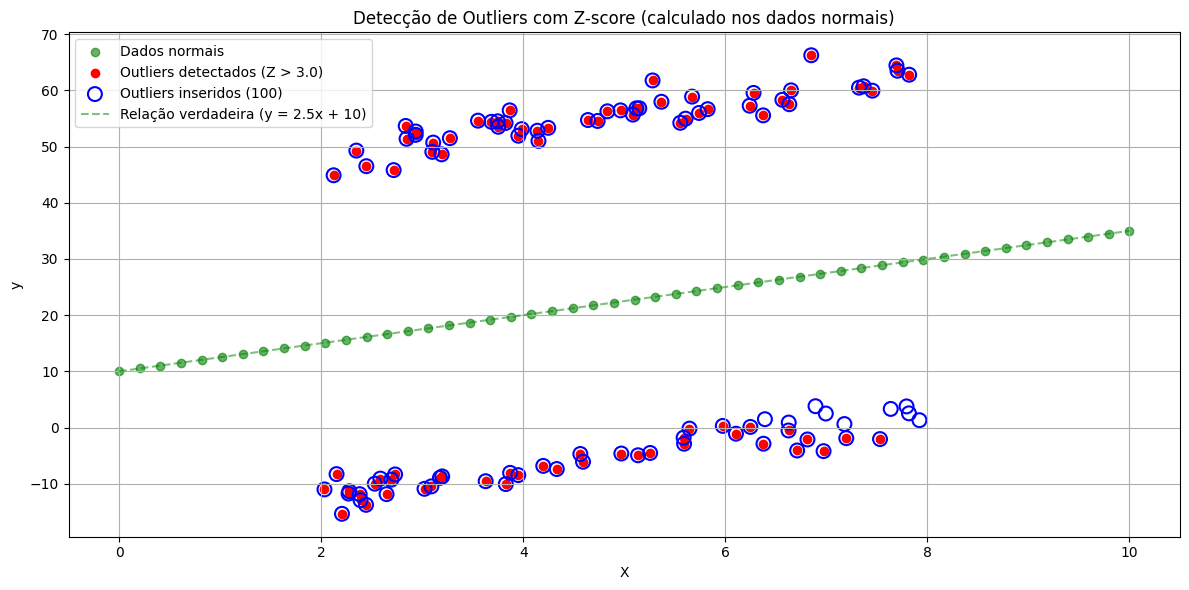

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers.synthetic_data import generate_linear_data


np.random.seed(43)
n_samples    = 50
n_outliers   = 100
offset       = 30
noise_std    = 1.0
limiar       = 3.0

# Geração dos dados com outliers
X, y = generate_linear_data(
    ang_coef=2.5,
    linear_coef=10.0,
    n_samples=n_samples,
    with_outliers=True,
    n_outliers=n_outliers,
    outlier_offset=offset,
    noise_std=noise_std,
)

data = pd.DataFrame({'X': X.ravel(), 'y': y})
data['Outlier_inserido'] = False
data.loc[n_samples:, 'Outlier_inserido'] = True

y_without_outliers = y[:n_samples]
mean_without_outliers = y_without_outliers.mean()
std_without_outliers = y_without_outliers.std()

data['Z_score'] = (data['y'] - mean_without_outliers) / std_without_outliers
data['Outlier_Zscore'] = data['Z_score'].abs() > limiar

plt.figure(figsize=(12, 6))

plt.scatter(data.loc[~data['Outlier_inserido'], 'X'],
            data.loc[~data['Outlier_inserido'], 'y'],
            color='green', alpha=0.6, label='Dados normais')

plt.scatter(data.loc[data['Outlier_Zscore'], 'X'],
            data.loc[data['Outlier_Zscore'], 'y'],
            color='red', label=f'Outliers detectados (Z > {limiar})')

plt.scatter(data.loc[data['Outlier_inserido'], 'X'],
            data.loc[data['Outlier_inserido'], 'y'],
            facecolors='none', edgecolors='blue', s=100,
            linewidths=1.5, label=f'Outliers inseridos ({n_outliers})')

idx_sorted = np.argsort(X[:n_samples].ravel())
X_norm_sorted = X[:n_samples].ravel()[idx_sorted]
y_norm_sorted = y[:n_samples][idx_sorted]

plt.plot(X_norm_sorted, y_norm_sorted, 'g--', alpha=0.5, label='Relação verdadeira (y = 2.5x + 10)')

plt.title("Detecção de Outliers com Z-score (calculado nos dados normais)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2 - Ajuste e Comparação de Modelos

- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html

In [10]:
LINEAR     = 'Linear'
SVR_LINEAR = 'SVR Linear'
RANSAC     = 'RANSAC'
HUBER      = 'Huber'

Linear: 563.3372990492819
SVR Linear: 561.8892717422244
RANSAC: 1055.6039527515986
Huber: 563.8510624341724


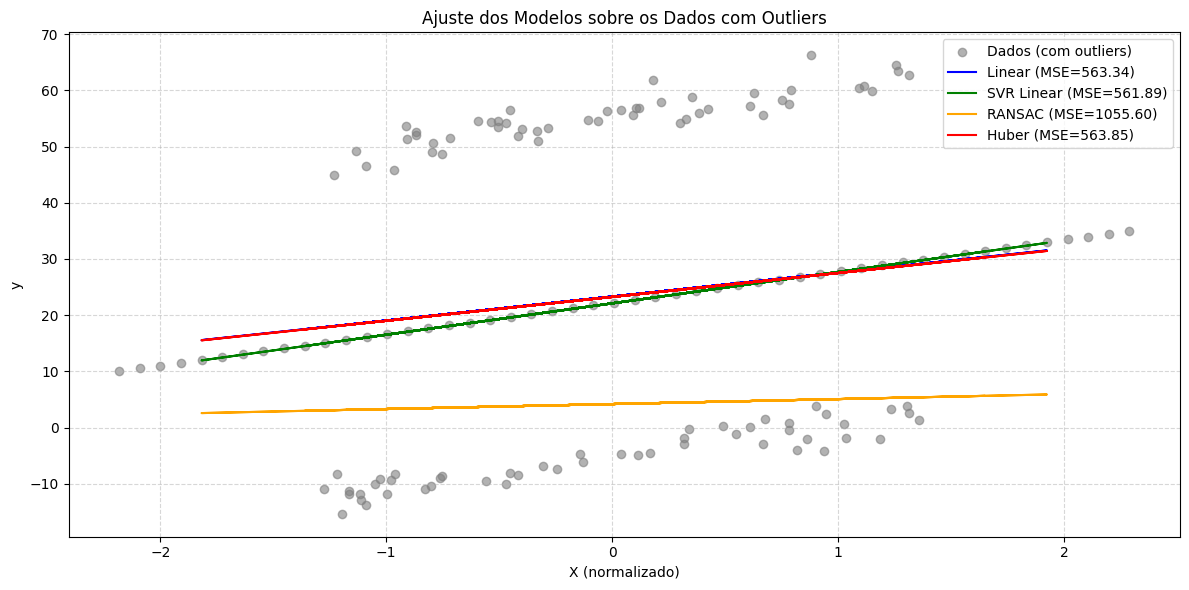

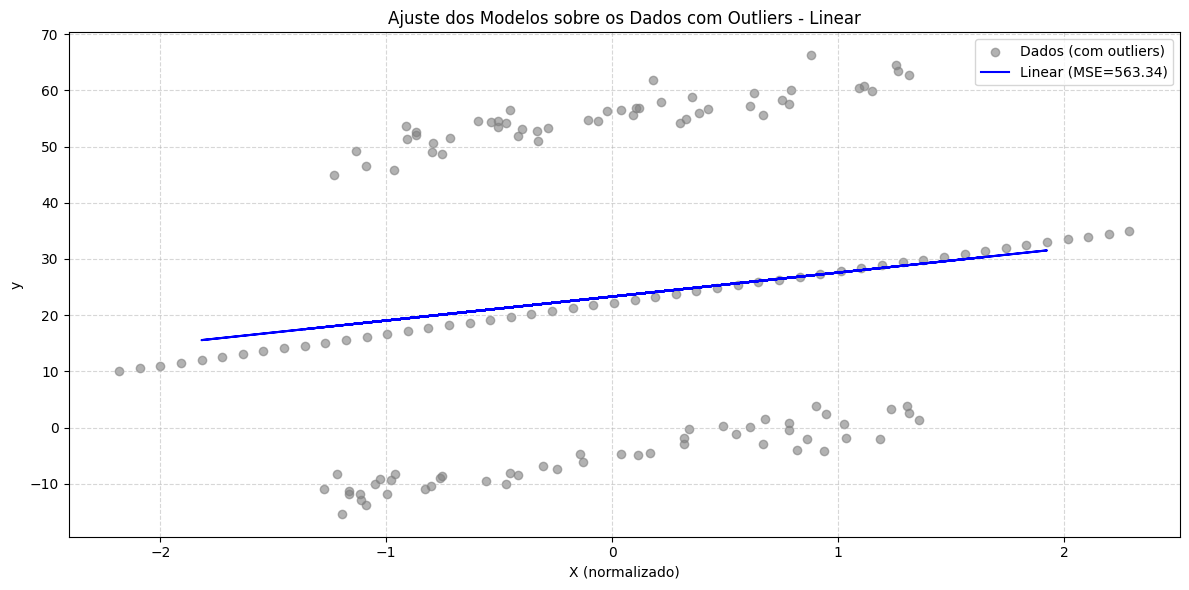

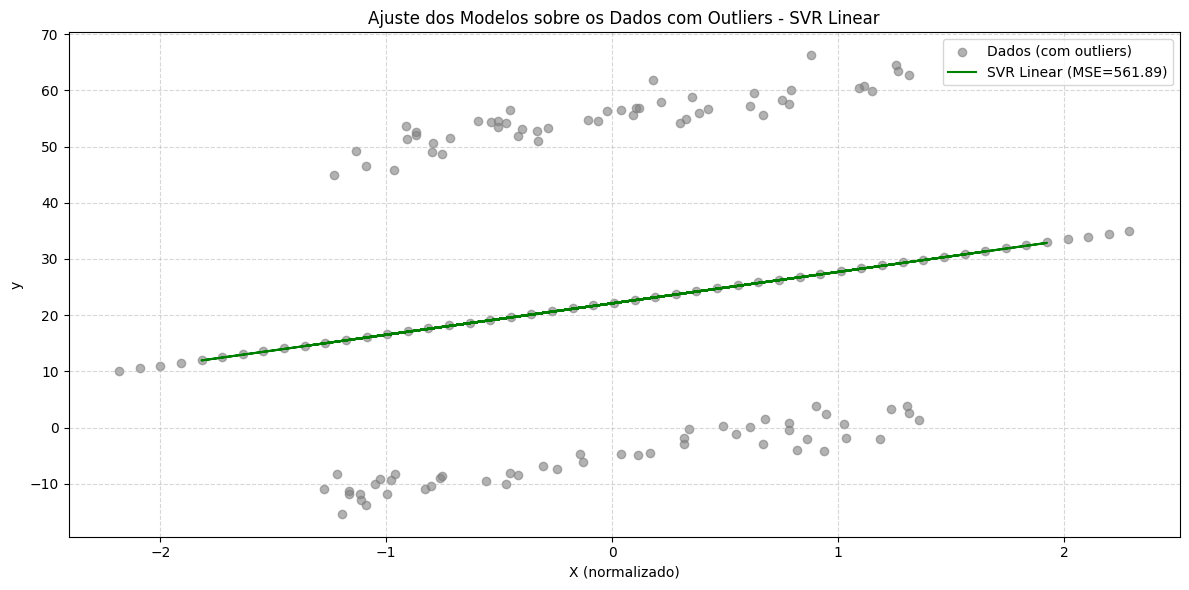

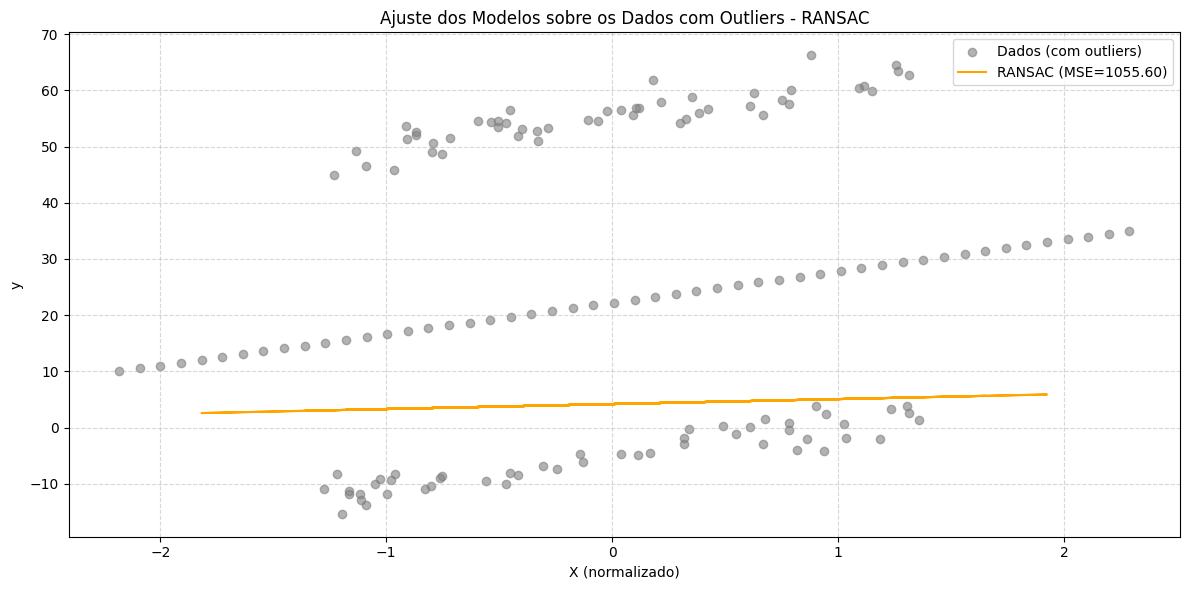

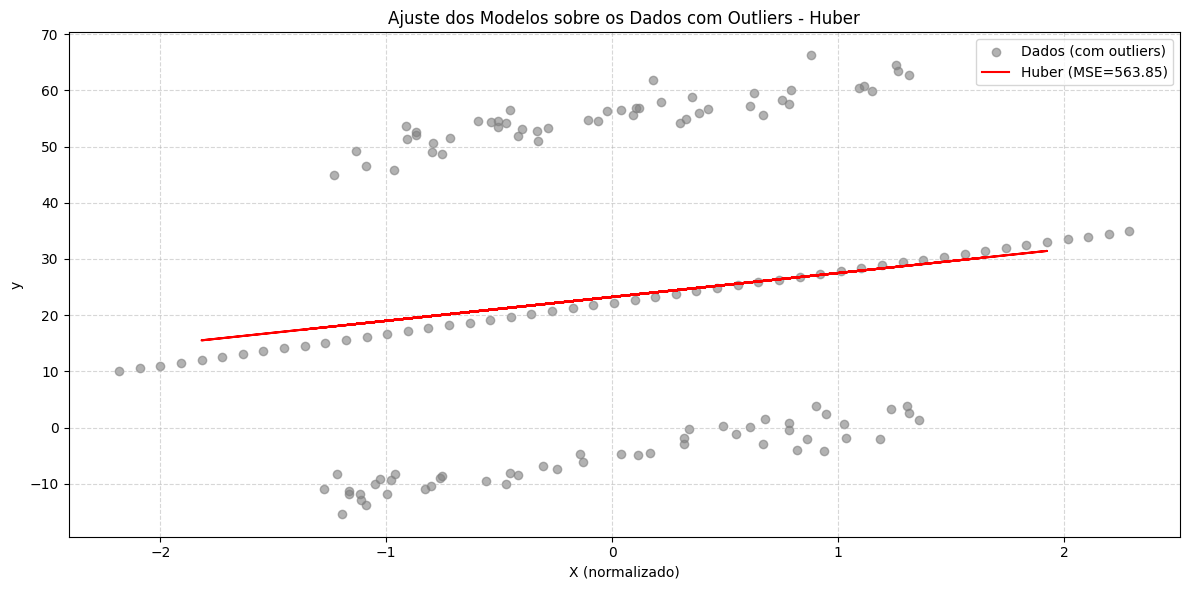

In [11]:
import seaborn as sns
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

models = {
    LINEAR: LinearRegression(),
    SVR_LINEAR: SVR(kernel='linear', C=10.0, epsilon=0.1),
    RANSAC: RANSACRegressor(),
    HUBER: HuberRegressor(epsilon=1.35)
}

predictions = dict()
mses = dict()

for algorithm, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[algorithm] = y_pred
    mses[algorithm] = mean_squared_error(y_test, y_pred)

for algorithm, mse in mses.items():
    print(f"{algorithm}: {mse}")


cores = {
    LINEAR: 'blue',
    SVR_LINEAR: 'green',
    RANSAC: 'orange',
    HUBER: 'red'
}


plt.figure(figsize=(12, 6))
plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (com outliers)')
for algorithm, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])
plt.title("Ajuste dos Modelos sobre os Dados com Outliers")
plt.xlabel("X (normalizado)")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


for algorithm, y_pred in predictions.items():
    plt.figure(figsize=(12, 6))
    plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (com outliers)')
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])
    plt.title(f"Ajuste dos Modelos sobre os Dados com Outliers - {algorithm}")
    plt.xlabel("X (normalizado)")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()



# 3 - Experimento: Remoção de Outliers

Linear: 6.037415461291477e-29
SVR Linear: 0.0032850042745169897
RANSAC: 6.037415461291477e-29
Huber: 9.041858201255441e-22


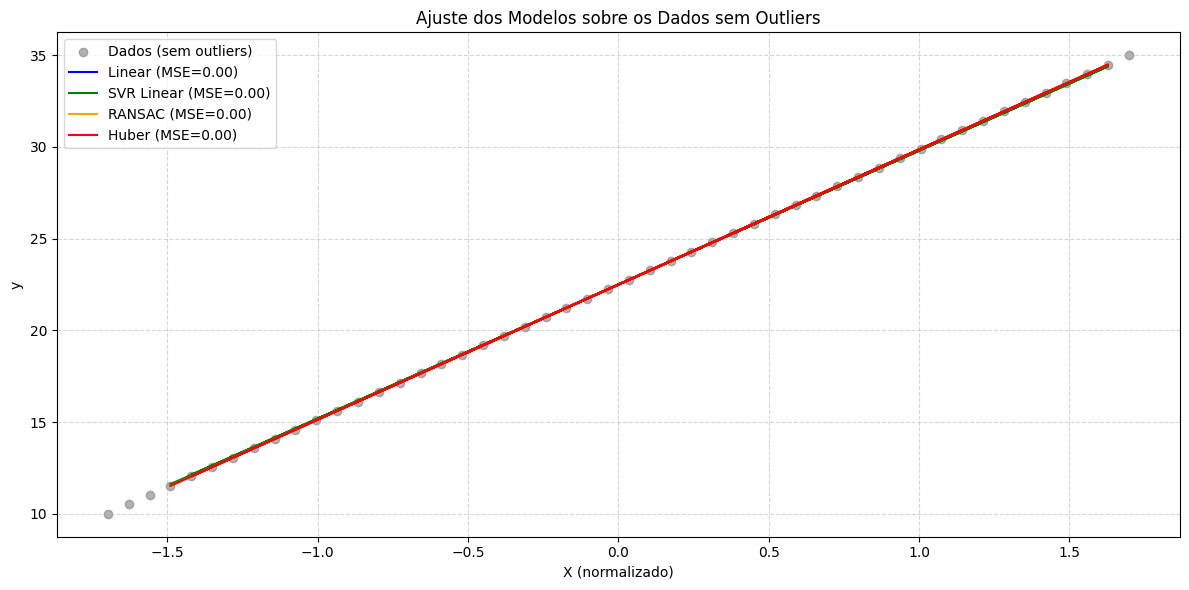

In [12]:
X, y = generate_linear_data(ang_coef=2.5, linear_coef=10.0, n_samples=n_samples)

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

for algorithm, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[algorithm] = y_pred
    mses[algorithm] = mean_squared_error(y_test, y_pred)

for algorithm, mse in mses.items():
    print(f"{algorithm}: {mse}")

plt.figure(figsize=(12, 6))
plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (sem outliers)')

cores = {
    LINEAR: 'blue',
    SVR_LINEAR: 'green',
    RANSAC: 'orange',
    HUBER: 'red'
}

for algorithm, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])

plt.title("Ajuste dos Modelos sobre os Dados sem Outliers")
plt.xlabel("X (normalizado)")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 4 - Análise Crítica

### Qual modelo demonstrou maior robustez aos outliers? Justifique com base nos gráficos e nos valores de MSE. 

> De acordo com os gráficos e os valores de erro médio quadrático (MSE), o modelo que demonstrou maior robustez à presença de outliers foi o SVR com kernel linear. Além de apresentar o menor MSE entre os modelos avaliados, sua reta de ajuste manteve-se próxima à tendência central dos dados, mesmo com a forte influência dos outliers. Visualmente, o SVR linear conseguiu capturar melhor a relação linear subjacente, sem ser excessivamente distorcido pelos pontos extremos, o que evidencia sua capacidade de preservar o padrão dos dados originais em cenários ruidosos.

### Os modelos robustos ainda apresentam vantagens após a remoção dos outliers?

> Não, após a remoção dos outliers, modelos robustos como o Huber e o RANSAC não apresentam vantagem sobre a regressão linear tradicional, pois todos os modelos se ajustaram perfeitamente à tendência linear dos dados, resultando em MSE igual a zero. O Huber e o RANSAC são projetados para reduzir a influência de pontos extremos, mas, na ausência desses outliers, seu comportamento se torna equivalente ao dos modelos clássicos. Nesse caso, o uso desses métodos robustos não traz ganho adicional de desempenho.

### É sempre melhor remover os outliers? Quando modelos robustos são preferíveis?

> Remover outliers nem sempre é a melhor escolha, pois eles podem conter informações importantes. Em contextos onde há incerteza sobre sua origem ou quando fazem parte natural dos dados, é mais apropriado utilizar modelos robustos, que reduzem sua influência sem eliminá-los, preservando a integridade e a representatividade do ajuste.


# 5 - Exploração Avançada

Linear: 6.037415461291477e-29
SVR Linear: 0.0032850042745169897
RANSAC: 6.037415461291477e-29
Huber: 9.041858201255441e-22


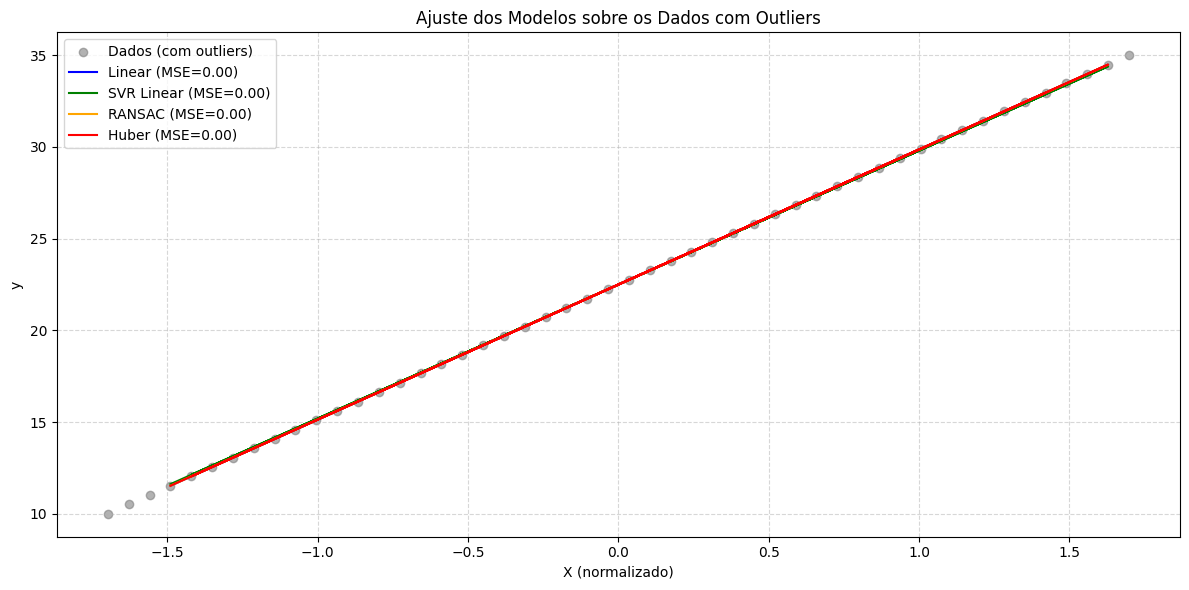

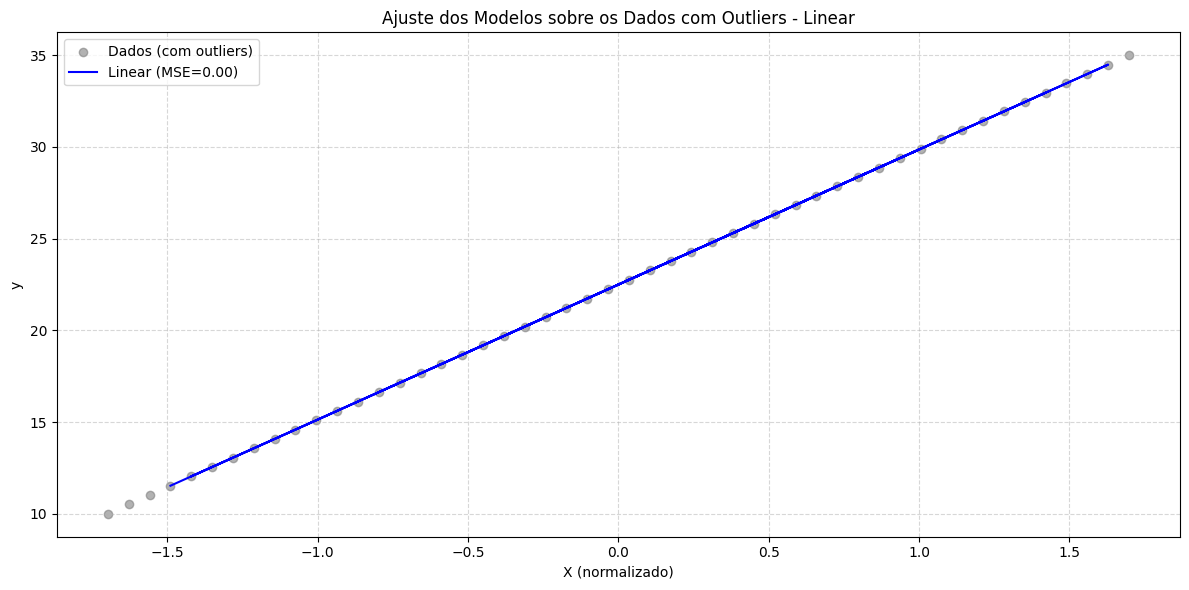

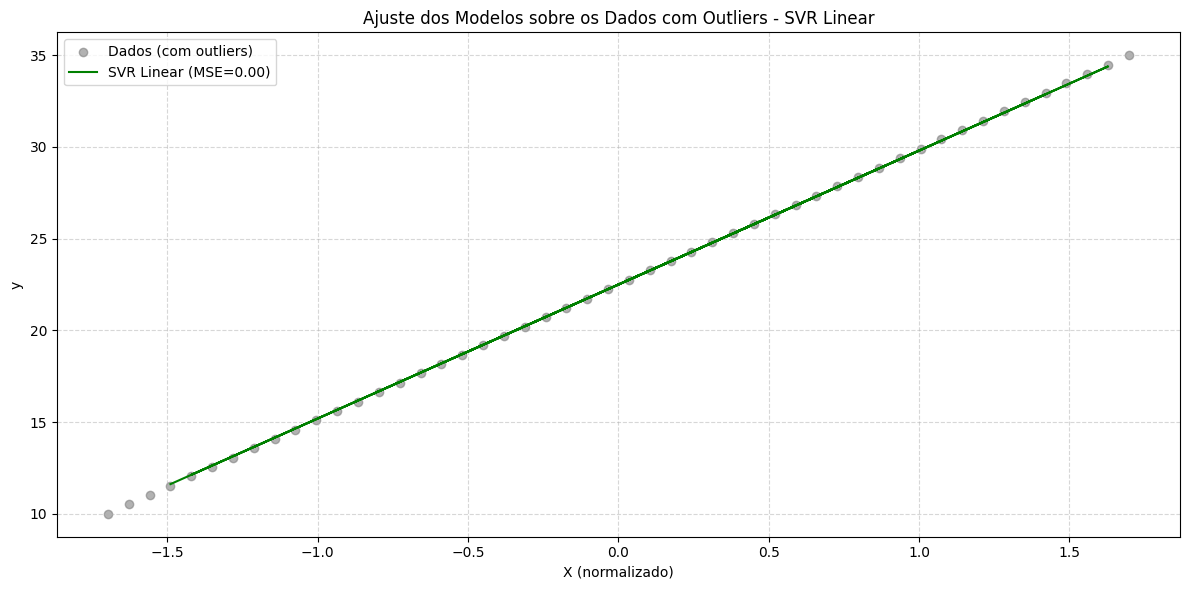

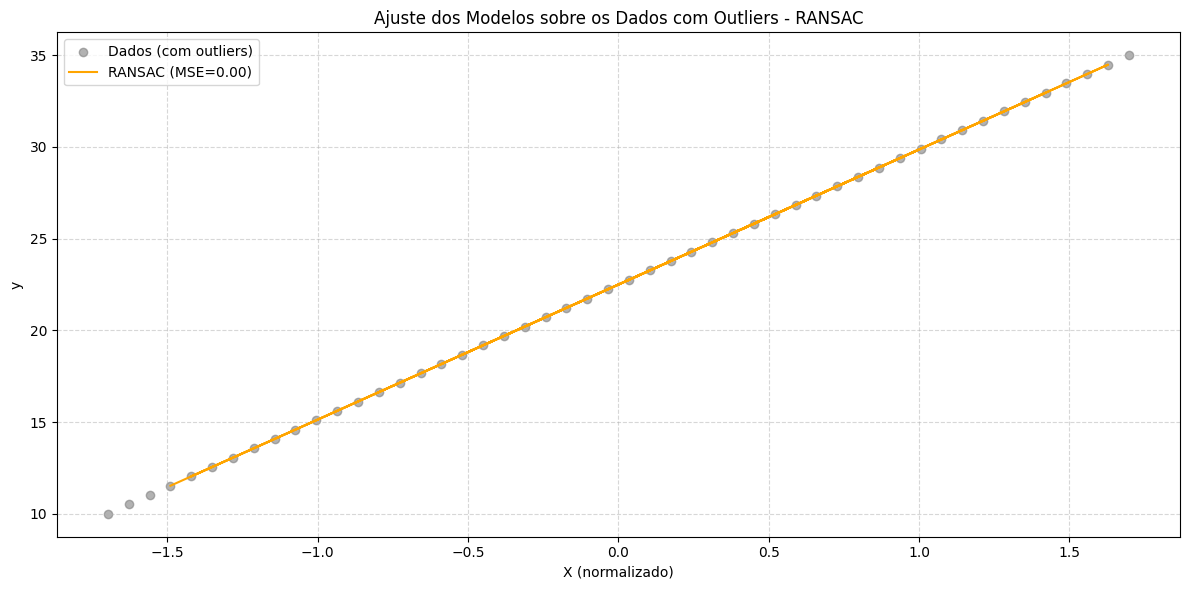

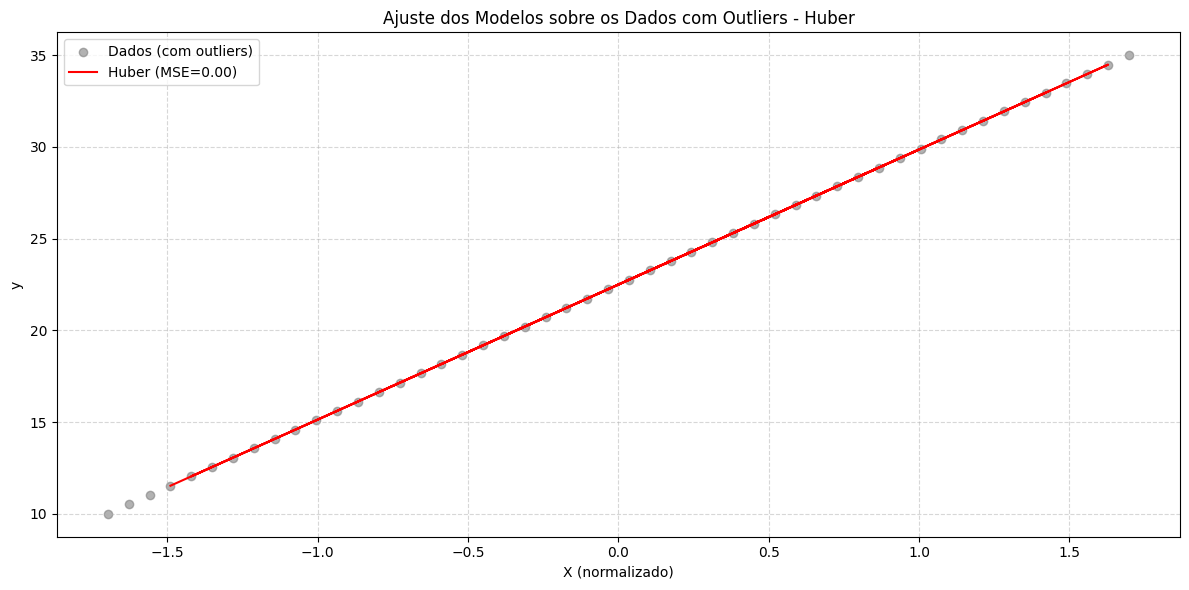

In [13]:
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

models = {
    LINEAR: LinearRegression(),
    SVR_LINEAR: SVR(kernel='linear', C=10.0, epsilon=0.1),
    RANSAC: RANSACRegressor(),
    HUBER: HuberRegressor(epsilon=1.35)
}

predictions = dict()
mses = dict()

for algorithm, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[algorithm] = y_pred
    mses[algorithm] = mean_squared_error(y_test, y_pred)

for algorithm, mse in mses.items():
    print(f"{algorithm}: {mse}")


cores = {
    LINEAR: 'blue',
    SVR_LINEAR: 'green',
    RANSAC: 'orange',
    HUBER: 'red'
}


plt.figure(figsize=(12, 6))
plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (com outliers)')
for algorithm, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])
plt.title("Ajuste dos Modelos sobre os Dados com Outliers")
plt.xlabel("X (normalizado)")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


for algorithm, y_pred in predictions.items():
    plt.figure(figsize=(12, 6))
    plt.scatter(X_scaled, y, color='gray', alpha=0.6, label='Dados (com outliers)')
    plt.plot(X_test, y_pred, label=f'{algorithm} (MSE={mses[algorithm]:.2f})', color=cores[algorithm])
    plt.title(f"Ajuste dos Modelos sobre os Dados com Outliers - {algorithm}")
    plt.xlabel("X (normalizado)")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

